In [1]:
%tensorflow_version 1.x
%matplotlib inline

import cv2
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import GlobalAveragePooling2D, BatchNormalization
from keras.utils import plot_model

import os
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [2]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [3]:
df = pd.read_csv('hvc_annotations.csv')
del df['filename']

# one hot encoding of labels
one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

df.shape

(13573, 9)

In [4]:
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [0]:
from skimage import io
from pathlib import Path

In [0]:
# images = np.array([cv2.resize(io.imread(p), (200, 200)) for p in df.iloc[:, -1]])
# mean = []
# std = []
# for i in range(images.shape[-1]):
#     pixels = images[:, :, :, i].ravel()
#     mean.append(np.mean(pixels))
#     std.append(np.std(pixels))

mean = [46.56585295255286, 41.46895223605688, 41.246545649451114]
std = [69.21208428987939, 63.936488294726296, 63.29494237674264]


In [7]:
mean, std

([46.56585295255286, 41.46895223605688, 41.246545649451114],
 [69.21208428987939, 63.936488294726296, 63.29494237674264])

In [24]:
# The image normalization part
im = cv2.resize(cv2.imread("resized/1.jpg"), (200, 200))
print(np.mean(im, axis=(0, 1)), np.max(im, axis=(0, 1)), np.min(im, axis=(0, 1)))
normalize_image = lambda x: (x - mean) / std
n_im = normalize_image(im)
print(np.mean(n_im, axis=(0, 1)), np.max(n_im, axis=(0, 1)), np.min(n_im, axis=(0, 1)), np.std(n_im, axis=(0, 1)))


[36.331175 40.312975 45.63045 ] [255 255 255] [0 0 0]
[-0.14787415 -0.01808009  0.06926153] [3.01152825 3.33973688 3.37710165] [-0.67279946 -0.64859603 -0.65165626] [0.89639136 1.01516481 1.11346625]


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    def __init__(self, df, batch_size=32, image_size=200, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.image_size = image_size
        self.normalize_image = lambda x: (x - mean) / std
        self.on_epoch_end()
        

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        
        # resizing the image to (self.image_size, self.image_size)
        image = np.stack([self.normalize_image(cv2.resize(cv2.imread(item["image_path"]), 
                                            (self.image_size, self.image_size))) for _, item in items.iterrows()])

        if self.augmentation is not None:
            # This is required for featurewise-center and featurewise-stdnorm
            # self.augmentation.fit(image)
            image = self.augmentation.flow(image, shuffle=False).next()

        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [0]:
np.random.seed(42)
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15, random_state=42)
train_df.shape, val_df.shape

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32, image_size=200, augmentation=ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    # preprocessing_function=get_random_eraser(v_h=1, s_l=0.01, s_h=0.2, r_1=0.1, r_2=1)
# ))
))

valid_gen = PersonDataGenerator(val_df, batch_size=32, image_size=200, shuffle=False)

In [11]:
# get number of output units from data
images, targets = next(iter(train_gen))
# num_units actually tells the number of one-hot encoded values / choices for a category
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Train Data Shape: (200, 200, 3), Validation Data Shape: (200, 200, 3)


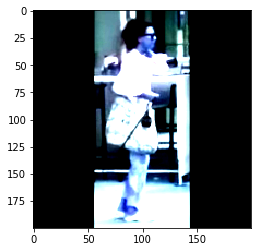

In [12]:
# This can act as the measure that val data is always the same
val_images, _ = next(iter(valid_gen))
plt.imshow(val_images[1]);
print()
print(f'Train Data Shape: {images[0].shape}, Validation Data Shape: {val_images[0].shape}')

In [36]:
print(np.mean(val_images[0], axis=(0, 1)), np.max(val_images[0], axis=(0, 1)), np.min(val_images[0], axis=(0, 1)), np.std(val_images[0], axis=(0, 1)))


[-0.0627492  -0.08412571  0.12959139] [3.01152825 3.30845583 3.23491019] [-0.67279946 -0.64859603 -0.65165626] [0.76925116 0.84839839 0.92387823]


In [0]:
backbone = DenseNet121(
    include_top=False,
    input_shape=(200, 200, 3),
    weights=None,

)

neck = GlobalAveragePooling2D()(backbone.output)

def build_tower(in_layer):
    neck = BatchNormalization()(in_layer)
    # neck = Dropout(0.4)(neck)
    neck = Dense(128, activation='relu')(neck)
    return neck

def build_head(name, in_layer):
    return Dense(num_units[name], activation='softmax', name=f'{name}_output')(in_layer)

#heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input,
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

In [0]:
model.load_weights('/content/gdrive/My Drive/Person_MultiClass/person_multiclass_model_densenet_200_normalized_frozen_augmented.h5')

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 100, 100, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [0]:
plot_model(model)

In [0]:
def check_all_layers_trainable(model):
    # skip the input layer
    for l in model.layers[1:]:
        assert l.trainable == True, "Complete Model is not trainable"

In [0]:
check_all_layers_trainable(model)

In [0]:
# reduce lr on plateau
reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=3,
    min_lr=1e-6,
    verbose=1,
    min_delta=1e-3
)

# save the model
save_dir = os.path.join(os.getcwd(), 'gdrive/My Drive/Person_MultiClass')
model_name = 'person_multiclass_model_densenet_200_normalized_frozen_augmented.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# checkpoint callback
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

# Early Stopping
early_stopping = EarlyStopping(
    patience=8,
    verbose=1,
    min_delta=1e-3,
    restore_best_weights=True
)

def compile_model(model):
    
    model.compile(
        optimizer=Adam(lr=0.0001),
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )

In [0]:
compile_model(model)

# for 50 epochs train on (100, 100, 3), with adam defaults, reduce_lr and no data augmentation
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    callbacks=[reduce_lr_on_plateau, checkpoint, early_stopping]
)

Epoch 1/50
360/360 [==============================] - 131s 364ms/step - loss: 10.6285 - gender_output_loss: 0.9666 - image_quality_output_loss: 1.2765 - age_output_loss: 1.8721 - weight_output_loss: 1.3288 - bag_output_loss: 1.2853 - footwear_output_loss: 1.3995 - pose_output_loss: 1.2825 - emotion_output_loss: 1.2171 - gender_output_acc: 0.5405 - image_quality_output_acc: 0.4991 - age_output_acc: 0.3437 - weight_output_acc: 0.5892 - bag_output_acc: 0.5131 - footwear_output_acc: 0.4770 - pose_output_acc: 0.5668 - emotion_output_acc: 0.6793 - val_loss: 29.0527 - val_gender_output_loss: 2.5265 - val_image_quality_output_loss: 3.1375 - val_age_output_loss: 4.2660 - val_weight_output_loss: 5.7552 - val_bag_output_loss: 3.1097 - val_footwear_output_loss: 5.1654 - val_pose_output_loss: 2.7604 - val_emotion_output_loss: 2.3320 - val_gender_output_acc: 0.5504 - val_image_quality_output_acc: 0.5514 - val_age_output_acc: 0.3770 - val_weight_output_acc: 0.4375 - val_bag_output_acc: 0.5544 - val_f

OSError: ignored

In [0]:
results = model.evaluate_generator(valid_gen, verbose=1)
dict(zip(model.metrics_names, results))

{'age_output_acc': 0.39163306451612906,
 'age_output_loss': 1.3995606553169988,
 'bag_output_acc': 0.5972782258064516,
 'bag_output_loss': 0.8735611573342354,
 'emotion_output_acc': 0.7061491935483871,
 'emotion_output_loss': 0.9112937200453973,
 'footwear_output_acc': 0.6108870967741935,
 'footwear_output_loss': 0.856645489892652,
 'gender_output_acc': 0.7011088709677419,
 'gender_output_loss': 0.5553501796337866,
 'image_quality_output_acc': 0.5650201612903226,
 'image_quality_output_loss': 0.9730678200721741,
 'loss': 7.36112920699581,
 'pose_output_acc': 0.6345766129032258,
 'pose_output_loss': 0.8405800269496057,
 'weight_output_acc': 0.6446572580645161,
 'weight_output_loss': 0.9510700318121141}

In [0]:
results = model.evaluate_generator(valid_gen, verbose=1)
dict(zip(model.metrics_names, results))

31/31 [==============================] - 4s 118ms/step


{'age_output_acc': 0.3956653225806452,
 'age_output_loss': 1.371255213214505,
 'bag_output_acc': 0.6244959677419355,
 'bag_output_loss': 0.8403560596127664,
 'emotion_output_acc': 0.7061491935483871,
 'emotion_output_loss': 0.9223791245491274,
 'footwear_output_acc': 0.6502016129032258,
 'footwear_output_loss': 0.814665227167068,
 'gender_output_acc': 0.7888104838709677,
 'gender_output_loss': 0.4484559710948698,
 'image_quality_output_acc': 0.5463709677419355,
 'image_quality_output_loss': 0.9537895898665151,
 'loss': 6.980772802906651,
 'pose_output_acc': 0.734375,
 'pose_output_loss': 0.6512295065387603,
 'weight_output_acc': 0.6446572580645161,
 'weight_output_loss': 0.9786421272062487}

In [0]:
results = model.evaluate_generator(valid_gen, verbose=1)
dict(zip(model.metrics_names, results))

31/31 [==============================] - 4s 115ms/step


{'age_output_acc': 0.3996975806451613,
 'age_output_loss': 1.3903749758197415,
 'bag_output_acc': 0.6330645161290323,
 'bag_output_loss': 0.8446257729684153,
 'emotion_output_acc': 0.7061491935483871,
 'emotion_output_loss': 0.9406370289864079,
 'footwear_output_acc': 0.6426411290322581,
 'footwear_output_loss': 0.8233564188403468,
 'gender_output_acc': 0.8034274193548387,
 'gender_output_loss': 0.43649363613897757,
 'image_quality_output_acc': 0.5504032258064516,
 'image_quality_output_loss': 0.9671380519866943,
 'loss': 7.060143440000473,
 'pose_output_acc': 0.7409274193548387,
 'pose_output_loss': 0.6812139711072368,
 'weight_output_acc': 0.6431451612903226,
 'weight_output_loss': 0.9763035851140176}

In [0]:
compile_model(model)
results = model.evaluate_generator(valid_gen, verbose=1)
for m, r in zip(model.metrics_names, results):
    if 'acc' in m:
        print(f'{m}: {r}')

31/31 [==============================] - 32s 1s/step
gender_output_acc: 0.8240927419354839
image_quality_output_acc: 0.5816532258064516
age_output_acc: 0.38810483870967744
weight_output_acc: 0.6345766129032258
bag_output_acc: 0.6537298387096774
footwear_output_acc: 0.6607862903225806
pose_output_acc: 0.7913306451612904
emotion_output_acc: 0.7056451612903226


In [0]:
compile_model(model)
results = model.evaluate_generator(valid_gen, verbose=1)
for m, r in zip(model.metrics_names, results):
    if 'acc' in m:
        print(f'{m}: {r}')

63/63 [==============================] - 23s 369ms/step
gender_output_acc: 0.8883928571428571
image_quality_output_acc: 0.5967261904761905
age_output_acc: 0.41220238095238093
weight_output_acc: 0.6349206349206349
bag_output_acc: 0.6964285714285714
footwear_output_acc: 0.6294642857142857
pose_output_acc: 0.8442460317460317
emotion_output_acc: 0.7043650793650794


In [0]:
compile_model(model)
results = model.evaluate_generator(valid_gen, verbose=1)
for m, r in zip(model.metrics_names, results):
    if 'acc' in m:
        print(f'{m}: {r}')

63/63 [==============================] - 29s 459ms/step
gender_output_acc: 0.8908730158730159
image_quality_output_acc: 0.5932539682539683
age_output_acc: 0.44047619047619047
weight_output_acc: 0.652281746031746
bag_output_acc: 0.6974206349206349
footwear_output_acc: 0.6577380952380952
pose_output_acc: 0.8601190476190477
emotion_output_acc: 0.7043650793650794


In [0]:
model.save('/content/gdrive/My Drive/Person_MultiClass/person_multiclass_model_densenet_200_normalized_v1.h5')

In [0]:
model.load_weights('/content/gdrive/My Drive/Person_MultiClass/person_multiclass_model_densenet_100.h5')

In [0]:
compile_model(model)

# for 50 epochs train on (100, 100, 3), with adam defaults, reduce_lr and no data augmentation
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    callbacks=[reduce_lr_on_plateau, checkpoint, early_stopping]
)

Epoch 1/50
360/360 [==============================] - 137s 380ms/step - loss: 7.2925 - gender_output_loss: 0.5713 - image_quality_output_loss: 0.9710 - age_output_loss: 1.3900 - weight_output_loss: 0.9666 - bag_output_loss: 0.8790 - footwear_output_loss: 0.8579 - pose_output_loss: 0.7673 - emotion_output_loss: 0.8894 - gender_output_acc: 0.7066 - image_quality_output_acc: 0.5486 - age_output_acc: 0.3987 - weight_output_acc: 0.6335 - bag_output_acc: 0.5918 - footwear_output_acc: 0.6095 - pose_output_acc: 0.6721 - emotion_output_acc: 0.7128 - val_loss: 7.2960 - val_gender_output_loss: 0.5658 - val_image_quality_output_loss: 0.9623 - val_age_output_loss: 1.4039 - val_weight_output_loss: 0.9596 - val_bag_output_loss: 0.8713 - val_footwear_output_loss: 0.8495 - val_pose_output_loss: 0.7811 - val_emotion_output_loss: 0.9026 - val_gender_output_acc: 0.7072 - val_image_quality_output_acc: 0.5645 - val_age_output_acc: 0.3876 - val_weight_output_acc: 0.6447 - val_bag_output_acc: 0.5953 - val_foo

In [0]:
# Now let's freeze the initial layers, and train a bit further
for l in model.layers[:427]:
    l.trainable = False 

for i, l in enumerate(model.layers):
    print(i, l, l.trainable)

In [0]:
compile_model(model)

# for 50 epochs train on (100, 100, 3), with adam defaults, reduce_lr and no data augmentation and frozen initial layers
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    callbacks=[reduce_lr_on_plateau, checkpoint, early_stopping]
)

Epoch 1/50
360/360 [==============================] - 58s 162ms/step - loss: 6.5428 - gender_output_loss: 0.3617 - image_quality_output_loss: 0.9443 - age_output_loss: 1.3462 - weight_output_loss: 0.9398 - bag_output_loss: 0.8157 - footwear_output_loss: 0.7407 - pose_output_loss: 0.5292 - emotion_output_loss: 0.8653 - gender_output_acc: 0.8460 - image_quality_output_acc: 0.5514 - age_output_acc: 0.4130 - weight_output_acc: 0.6369 - bag_output_acc: 0.6438 - footwear_output_acc: 0.6798 - pose_output_acc: 0.7866 - emotion_output_acc: 0.7101 - val_loss: 7.1298 - val_gender_output_loss: 0.5135 - val_image_quality_output_loss: 0.9556 - val_age_output_loss: 1.3717 - val_weight_output_loss: 0.9871 - val_bag_output_loss: 0.8501 - val_footwear_output_loss: 0.8493 - val_pose_output_loss: 0.6608 - val_emotion_output_loss: 0.9418 - val_gender_output_acc: 0.7807 - val_image_quality_output_acc: 0.5635 - val_age_output_acc: 0.3947 - val_weight_output_acc: 0.6346 - val_bag_output_acc: 0.6351 - val_foot

In [0]:
# Now's the time to unfreeze everything and try with higher resolution images
for l in model.layers:
    l.trainable = True

check_all_layers_trainable(model)

In [0]:
model.load_weights('/content/gdrive/My Drive/Person_MultiClass/person_multiclass_model_densenet_100_v1_frozen.h5')

In [0]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_9 (ZeroPadding2D (None, 206, 206, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 100, 100, 64) 9408        zero_padding2d_9[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [0]:
check_all_layers_trainable(model)

In [0]:
compile_model(model)

# for 50 epochs train on (200, 200, 3), with reduce_lr, early stopping, no data augmentation
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    callbacks=[reduce_lr_on_plateau, checkpoint, early_stopping]
)

Epoch 1/50
360/360 [==============================] - 254s 705ms/step - loss: 6.9499 - gender_output_loss: 0.4700 - image_quality_output_loss: 0.9283 - age_output_loss: 1.3754 - weight_output_loss: 0.9548 - bag_output_loss: 0.8539 - footwear_output_loss: 0.8093 - pose_output_loss: 0.6844 - emotion_output_loss: 0.8737 - gender_output_acc: 0.7766 - image_quality_output_acc: 0.5577 - age_output_acc: 0.4029 - weight_output_acc: 0.6339 - bag_output_acc: 0.6071 - footwear_output_acc: 0.6390 - pose_output_acc: 0.7097 - emotion_output_acc: 0.7124 - val_loss: 6.9345 - val_gender_output_loss: 0.4449 - val_image_quality_output_loss: 0.9275 - val_age_output_loss: 1.3793 - val_weight_output_loss: 0.9659 - val_bag_output_loss: 0.8438 - val_footwear_output_loss: 0.8206 - val_pose_output_loss: 0.6353 - val_emotion_output_loss: 0.9172 - val_gender_output_acc: 0.7918 - val_image_quality_output_acc: 0.5675 - val_age_output_acc: 0.3846 - val_weight_output_acc: 0.6260 - val_bag_output_acc: 0.6149 - val_foo

In [0]:
from keras.optimizers import Optimizer
from keras.utils import get_custom_objects


class LearningRateMultiplier(Optimizer):
    """Optimizer wrapper for per layer learning rate.
    This wrapper is used to add per layer learning rates by
    providing per layer factors which are multiplied with the
    learning rate of the optimizer.
    Note: This is a wrapper and does not implement any
    optimization algorithm.
    # Arguments
        optimizer: An optimizer class to be wrapped.
        lr_multipliers: Dictionary of the per layer factors. For
            example `optimizer={'conv_1/kernel':0.5, 'conv_1/bias':0.1}`.
            If for kernel and bias the same learning rate is used, the
            user can specify `optimizer={'conv_1':0.5}`.
        **kwargs: The arguments for instantiating the wrapped optimizer
            class.
    """
    def __init__(self, optimizer, lr_multipliers=None, **kwargs):
        self._class = optimizer
        self._optimizer = optimizer(**kwargs)
        self._lr_multipliers = lr_multipliers or {}

    def _get_multiplier(self, param):
        for k in self._lr_multipliers.keys():
            if k in param.name:
                return self._lr_multipliers[k]

    def get_updates(self, loss, params):
        mult_lr_params = {p: self._get_multiplier(p) for p in params
                          if self._get_multiplier(p)}
        base_lr_params = [p for p in params if self._get_multiplier(p) is None]

        updates = []
        base_lr = self._optimizer.lr
        for param, multiplier in mult_lr_params.items():
            self._optimizer.lr = base_lr * multiplier
            updates.extend(self._optimizer.get_updates(loss, [param]))

        self._optimizer.lr = base_lr
        updates.extend(self._optimizer.get_updates(loss, base_lr_params))

        return updates

    def get_config(self):
        config = {'optimizer': self._class,
                  'lr_multipliers': self._lr_multipliers}
        base_config = self._optimizer.get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def __getattr__(self, name):
        return getattr(self._optimizer, name)

    def __setattr__(self, name, value):
        if name.startswith('_'):
            super(LearningRateMultiplier, self).__setattr__(name, value)
        else:
            self._optimizer.__setattr__(name, value)


get_custom_objects().update({'LearningRateMultiplier': LearningRateMultiplier})

In [0]:
model.load_weights('/content/gdrive/My Drive/Person_MultiClass/person_multiclass_model_densenet_200.h5')

In [0]:
multipliers = {}
for index, layer in enumerate(backbone.layers):
    if index < len(backbone.layers) / 3:
        multipliers[layer.name] =  1e-6
    elif index < len(backbone.layers) * 2 / 3:
        multipliers[layer.name] = 1e-5
    else:
        multipliers[layer.name]=1e-4
multipliers

In [0]:
for layer in model.layers[len(backbone.layers):]:
    multipliers[layer.name] = 1e-3

In [0]:
opt = LearningRateMultiplier(SGD, lr_multipliers=multipliers, momentum=0.9, nesterov=True)

In [0]:
%ls

sample_data/


In [0]:
model.load_weights('/content/gdrive/My Drive/Person_MultiClass/person_multiclass_model_densenet_200.h5')

In [0]:
compile_model(model)

# for 50 epochs train on (200, 200, 3), with reduce_lr, early stopping, no data augmentation
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    callbacks=[reduce_lr_on_plateau, checkpoint, early_stopping]
)

Epoch 1/50
360/360 [==============================] - 243s 675ms/step - loss: 7.2125 - gender_output_loss: 0.5221 - image_quality_output_loss: 0.9401 - age_output_loss: 1.3991 - weight_output_loss: 0.9718 - bag_output_loss: 0.8688 - footwear_output_loss: 0.8903 - pose_output_loss: 0.7309 - emotion_output_loss: 0.8894 - gender_output_acc: 0.7398 - image_quality_output_acc: 0.5535 - age_output_acc: 0.4015 - weight_output_acc: 0.6343 - bag_output_acc: 0.6009 - footwear_output_acc: 0.5919 - pose_output_acc: 0.6845 - emotion_output_acc: 0.7128 - val_loss: 7.4675 - val_gender_output_loss: 0.4199 - val_image_quality_output_loss: 0.9254 - val_age_output_loss: 1.3977 - val_weight_output_loss: 1.0028 - val_bag_output_loss: 0.8464 - val_footwear_output_loss: 1.1514 - val_pose_output_loss: 0.8156 - val_emotion_output_loss: 0.9083 - val_gender_output_acc: 0.8085 - val_image_quality_output_acc: 0.5689 - val_age_output_acc: 0.3958 - val_weight_output_acc: 0.6215 - val_bag_output_acc: 0.6166 - val_foo

OSError: ignored

In [0]:
compile_model(model)

# for 50 epochs train on (200, 200, 3), with reduce_lr, early stopping, no data augmentation
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    callbacks=[reduce_lr_on_plateau, checkpoint, early_stopping]
)

Epoch 1/50
360/360 [==============================] - 251s 698ms/step - loss: 5.7250 - gender_output_loss: 0.2240 - image_quality_output_loss: 0.8542 - age_output_loss: 1.2293 - weight_output_loss: 0.8311 - bag_output_loss: 0.6838 - footwear_output_loss: 0.7377 - pose_output_loss: 0.3392 - emotion_output_loss: 0.8257 - gender_output_acc: 0.9097 - image_quality_output_acc: 0.5927 - age_output_acc: 0.4563 - weight_output_acc: 0.6675 - bag_output_acc: 0.7204 - footwear_output_acc: 0.6730 - pose_output_acc: 0.8757 - emotion_output_acc: 0.7135 - val_loss: 6.1829 - val_gender_output_loss: 0.2453 - val_image_quality_output_loss: 0.9001 - val_age_output_loss: 1.2741 - val_weight_output_loss: 0.8948 - val_bag_output_loss: 0.7365 - val_footwear_output_loss: 0.8112 - val_pose_output_loss: 0.4364 - val_emotion_output_loss: 0.8846 - val_gender_output_acc: 0.8973 - val_image_quality_output_acc: 0.5724 - val_age_output_acc: 0.4266 - val_weight_output_acc: 0.6498 - val_bag_output_acc: 0.6900 - val_foo

In [0]:
compile_model(model)

# for 50 epochs train on (200, 200, 3), with reduce_lr, early stopping, no data augmentation
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    callbacks=[reduce_lr_on_plateau, checkpoint, early_stopping]
)

Epoch 1/50
360/360 [==============================] - 261s 724ms/step - loss: 5.4905 - gender_output_loss: 0.1894 - image_quality_output_loss: 0.8392 - age_output_loss: 1.1806 - weight_output_loss: 0.7978 - bag_output_loss: 0.6445 - footwear_output_loss: 0.7197 - pose_output_loss: 0.3064 - emotion_output_loss: 0.8130 - gender_output_acc: 0.9263 - image_quality_output_acc: 0.6027 - age_output_acc: 0.4740 - weight_output_acc: 0.6786 - bag_output_acc: 0.7375 - footwear_output_acc: 0.6837 - pose_output_acc: 0.8840 - emotion_output_acc: 0.7135 - val_loss: 6.1606 - val_gender_output_loss: 0.2626 - val_image_quality_output_loss: 0.8793 - val_age_output_loss: 1.2798 - val_weight_output_loss: 0.9003 - val_bag_output_loss: 0.7424 - val_footwear_output_loss: 0.7926 - val_pose_output_loss: 0.4228 - val_emotion_output_loss: 0.8808 - val_gender_output_acc: 0.9048 - val_image_quality_output_acc: 0.5913 - val_age_output_acc: 0.4370 - val_weight_output_acc: 0.6424 - val_bag_output_acc: 0.7014 - val_foo

In [0]:
model.load_weights('/content/gdrive/My Drive/Person_MultiClass/person_multiclass_model_densenet_200_normalized.h5')

In [0]:
for l in backbone.layers:
    l.trainable = False

try:
    check_all_layers_trainable(model)
except AssertionError:
    for l in model.layers:
        print(l.name, l.trainable)

In [0]:
compile_model(model)

model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    callbacks=[reduce_lr_on_plateau, checkpoint, early_stopping]
)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
360/360 [==============================] - 183s 509ms/step - loss: 5.5681 - gender_output_loss: 0.2059 - image_quality_output_loss: 0.8399 - age_output_loss: 1.1948 - weight_output_loss: 0.8057 - bag_output_loss: 0.6544 - footwear_output_loss: 0.7317 - pose_output_loss: 0.3136 - emotion_output_loss: 0.8219 - gender_output_acc: 0.9198 - image_quality_output_acc: 0.6022 - age_output_acc: 0.4741 - weight_output_acc: 0.6773 - bag_output_acc: 0.7322 - footwear_output_acc: 0.6786 - pose_output_acc: 0.8862 - emotion_output_acc: 0.7144 - val_loss: 6.1222 - val_gender_output_loss: 0.2614 - val_image_quality_output_loss: 0.8823 - val_age_output_loss: 1.2627 - val_weight_output_loss: 0.8957 - val_bag_output_loss: 0.7391 - val_footwear_output_loss: 0.7876 - val_pose_output_loss: 0.4222 - val_emotion_output_loss: 0.8713 - val_gender_output_acc: 0.8929 - val_image_quality_output_acc: 0.5952 -

In [0]:
def freeze_model(model: keras.Model):
    for l in model.layers:
        l.trainable = False

def unfreeze_model(model: keras.Model):
    for l in model.layers:
        l.trainable = True

def print_layer_name_and_trainability(model: keras.Model):
    for l in model.layers:
        print(l.name, l.trainable)

In [0]:
def show_results(model: keras.Model):
    data = []
    results = model.evaluate_generator(valid_gen, verbose=1)
    for m, r in zip(model.metrics_names, results):
        if 'acc' in m:
            data.append({'metric_name': m, 'accuracy': r})
    
    df = pd.DataFrame(data, columns=['metric_name', 'accuracy'])
    print(df)

In [0]:
show_results(model)

63/63 [==============================] - 14s 228ms/step
                metric_name  accuracy
0         gender_output_acc  0.892857
1  image_quality_output_acc  0.595238
2            age_output_acc  0.443948
3         weight_output_acc  0.647817
4            bag_output_acc  0.702877
5       footwear_output_acc  0.656746
6           pose_output_acc  0.857639
7        emotion_output_acc  0.704365


In [0]:
model.load_weights('/content/gdrive/My Drive/Person_MultiClass/person_multiclass_model_densenet_200_normalized_frozen.h5')

In [24]:
compile_model(model)
results = model.evaluate_generator(valid_gen, verbose=1)
dict(zip(model.metrics_names, results))



63/63 [==============================] - 16s 255ms/step


{'age_output_acc': 0.44742063492063494,
 'age_output_loss': 1.261447342615279,
 'bag_output_acc': 0.6979166666666666,
 'bag_output_loss': 0.746320420787448,
 'emotion_output_acc': 0.7043650793650794,
 'emotion_output_loss': 0.8746356353873298,
 'footwear_output_acc': 0.6706349206349206,
 'footwear_output_loss': 0.7600492735703787,
 'gender_output_acc': 0.8888888888888888,
 'gender_output_loss': 0.2673757585977751,
 'image_quality_output_acc': 0.5848214285714286,
 'image_quality_output_loss': 0.8832696099129934,
 'loss': 6.113962423233759,
 'pose_output_acc': 0.8571428571428571,
 'pose_output_loss': 0.41937071794555303,
 'weight_output_acc': 0.6527777777777778,
 'weight_output_loss': 0.901493647741893}

In [46]:
compile_model(model)
show_results(model)



63/63 [==============================] - 18s 282ms/step
                metric_name  accuracy
0         gender_output_acc  0.888889
1  image_quality_output_acc  0.584821
2            age_output_acc  0.447421
3         weight_output_acc  0.652778
4            bag_output_acc  0.697917
5       footwear_output_acc  0.670635
6           pose_output_acc  0.857143
7        emotion_output_acc  0.704365


In [0]:
print_layer_name_and_trainability(model)

In [49]:
compile_model(model)

model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    callbacks=[reduce_lr_on_plateau, checkpoint, early_stopping]
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
360/360 [==============================] - 231s 640ms/step - loss: 5.4047 - gender_output_loss: 0.1704 - image_quality_output_loss: 0.8348 - age_output_loss: 1.1734 - weight_output_loss: 0.7895 - bag_output_loss: 0.6412 - footwear_output_loss: 0.7098 - pose_output_loss: 0.2754 - emotion_output_loss: 0.8102 - gender_output_acc: 0.9339 - image_quality_output_acc: 0.6098 - age_output_acc: 0.4821 - weight_output_acc: 0.6819 - bag_output_acc: 0.7352 - footwear_output_acc: 0.6872 - pose_output_acc: 0.9021 - emotion_output_acc: 0.7132 - val_loss: 6.1328 - val_gender_output_loss: 0.2514 - val_image_quality_output_loss: 0.9170 - val_age_output_loss: 1.2655 - val_weight_output_loss: 0.9048 - val_bag_output_loss: 0.7346 - val_footwear_output_loss: 0.7543 - val_pose_output_loss: 0.4251 - val_emotion_output_loss: 0.8802 - val_gender_output_acc: 0.9048 - val_image_quality_output_acc: 0.5729 - v

In [27]:
compile_model(model)

model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    callbacks=[reduce_lr_on_plateau, checkpoint, early_stopping]
)

Epoch 1/50
360/360 [==============================] - 204s 568ms/step - loss: 5.6000 - gender_output_loss: 0.2149 - image_quality_output_loss: 0.8433 - age_output_loss: 1.1972 - weight_output_loss: 0.8146 - bag_output_loss: 0.6640 - footwear_output_loss: 0.7236 - pose_output_loss: 0.3270 - emotion_output_loss: 0.8153 - gender_output_acc: 0.9118 - image_quality_output_acc: 0.6064 - age_output_acc: 0.4730 - weight_output_acc: 0.6779 - bag_output_acc: 0.7256 - footwear_output_acc: 0.6806 - pose_output_acc: 0.8780 - emotion_output_acc: 0.7135 - val_loss: 6.1614 - val_gender_output_loss: 0.2576 - val_image_quality_output_loss: 0.9240 - val_age_output_loss: 1.2608 - val_weight_output_loss: 0.9073 - val_bag_output_loss: 0.7333 - val_footwear_output_loss: 0.7642 - val_pose_output_loss: 0.4300 - val_emotion_output_loss: 0.8840 - val_gender_output_acc: 0.9067 - val_image_quality_output_acc: 0.5650 - val_age_output_acc: 0.4484 - val_weight_output_acc: 0.6458 - val_bag_output_acc: 0.7024 - val_foo

Process ForkPoolWorker-86:
Process ForkPoolWorker-95:
Process ForkPoolWorker-92:
Process ForkPoolWorker-91:
Process ForkPoolWorker-93:
Process ForkPoolWorker-89:
Process ForkPoolWorker-94:
Process ForkPoolWorker-88:
Process ForkPoolWorker-85:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-96:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-87:
Traceback (most recent call last):
Process ForkPoolWorker-90:
  File "/usr/lib/python3.6/multiprocessing/process.

KeyboardInterrupt: ignored

In [0]:
freeze_model(backbone)
print_layer_name_and_trainability(model)

In [33]:
compile_model(model)

model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    callbacks=[reduce_lr_on_plateau, checkpoint, early_stopping]
)

Epoch 1/50
360/360 [==============================] - 156s 435ms/step - loss: 5.7847 - gender_output_loss: 0.2350 - image_quality_output_loss: 0.8520 - age_output_loss: 1.2216 - weight_output_loss: 0.8372 - bag_output_loss: 0.6897 - footwear_output_loss: 0.7511 - pose_output_loss: 0.3630 - emotion_output_loss: 0.8351 - gender_output_acc: 0.9066 - image_quality_output_acc: 0.5945 - age_output_acc: 0.4636 - weight_output_acc: 0.6666 - bag_output_acc: 0.7141 - footwear_output_acc: 0.6643 - pose_output_acc: 0.8628 - emotion_output_acc: 0.7131 - val_loss: 6.1198 - val_gender_output_loss: 0.2782 - val_image_quality_output_loss: 0.8843 - val_age_output_loss: 1.2607 - val_weight_output_loss: 0.8958 - val_bag_output_loss: 0.7491 - val_footwear_output_loss: 0.7571 - val_pose_output_loss: 0.4248 - val_emotion_output_loss: 0.8697 - val_gender_output_acc: 0.8889 - val_image_quality_output_acc: 0.5898 - val_age_output_acc: 0.4489 - val_weight_output_acc: 0.6538 - val_bag_output_acc: 0.6930 - val_foo

In [0]:
print_layer_name_and_trainability(model)

In [23]:
compile_model(model)

model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    callbacks=[reduce_lr_on_plateau, checkpoint, early_stopping]
)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
360/360 [==============================] - 261s 726ms/step - loss: 5.3453 - gender_output_loss: 0.1693 - image_quality_output_loss: 0.8274 - age_output_loss: 1.1637 - weight_output_loss: 0.7849 - bag_output_loss: 0.6259 - footwear_output_loss: 0.7026 - pose_output_loss: 0.2697 - emotion_output_loss: 0.8017 - gender_output_acc: 0.9383 - image_quality_output_acc: 0.6093 - age_output_acc: 0.4910 - weight_output_acc: 0.6850 - bag_output_acc: 0.7424 - footwear_output_acc: 0.6903 - pose_output_acc: 0.9012 - emotion_output_acc: 0.7164 - val_loss: 6.1755 - val_gender_output_loss: 0.2638 - val_image_quality_output_loss: 0.9207 - val_age_output_loss: 1.2689 - val_weight_output_loss: 0.9091 - val_bag_output_loss: 0.7499 - val_footwear_output_loss: 0.7554 - val_pose_output_loss: 0.4260 - val_emotion_output_loss: 0.8817 - val_gender_output_acc: 0.9067 - val_image_quality_output_acc: 0.5689 -